In [1]:
import numpy as np
from numpy.fft import rfft,irfft, rfftfreq
import scipy
import scipy.interpolate as scint
import vlsr
import vlsr_iraf
from xkeckhelio import x_keckhelio
import fitsio
dir='/astro/u/anze/bmxdata/reduced/pas/200101_1600'
import matplotlib.pyplot as plt
import bmxhi4
from matplotlib.colors import LogNorm
from numpy.fft import rfft2,rfft
import scipy.linalg as la
dT=2**25/1.1e9*32
from matplotlib.colors import LogNorm

In [2]:
wires=[x.replace('\n','') for x in open(dir+'/wires').readlines()]
freq=fitsio.read(dir+'/cut1/freq.fits')
coords=fitsio.read(dir+'/coords.fits')
diode=fitsio.read(dir+'/diode.fits')
ra=coords['ra']

In [3]:
i=0
N=len(diode)
donoff=[]
while (diode[i]>0):
        i+=1
while True:
    while (diode[i]==0):
        i+=1
        if i==N: break
    if i==N: break
    st=i
    while (diode[i]>0):
        i+=1
        if i==N: break
    if i==N: break
    donoff.append((st,i))
donoff=donoff[1:-1] ## skip first and last one

In [4]:
def process_diode(da,diode):
    di=[]
    for i,j in donoff:
        h=(j-i)
        a=i-h
        b=j+h
        diff=da[i:j].mean(axis=0)-0.5*(da[a:i].mean(axis=0)+da[j:b].mean(axis=0))
        di.append(diff)
        da[i:i+h//2]=da[i-h//2:i]
        da[i+h//2:j]=da[j:j+(j-i-h//2)]
    di=np.array(di)
    afreq=di.mean(axis=0)
    atime=di.mean(axis=1)
    return da,afreq, atime

In [5]:
def measure_rfi(vec,returnbad=False):
    vecout=np.copy(vec)
    bad=[]
    for i in range(2,len(vec)-2):
        #print (i,(vec[i]+vec[i+1])/(vec[i-1]+vec[i+2]))
        if i in bad:
            continue
        if (freq[i]>1420.3)and(freq[i]<1420.5):
            continue ## actual peak of 21cm, hard to tell
        if (vec[i]/vec[i-1])>1.005:
            ## jump up
            
            if (vec[i]/vec[i+1])>1.005:
                bad.append(i)
                vecout[i]=0.5*(vec[i-1]+vec[i+1])
            elif (vec[i]/vec[i+2])>1.005:
                bad.append(i)
                bad.append(i+1)
                vecout[i]=0.5*(vec[i-1]+vec[i+2])
                vecout[i+1]=0.5*(vec[i-1]+vec[i+2])
    if returnbad:
        return bad,vecout
    rfi=(vec-vecout).sum()/vecout.sum()
    nrfi=len(bad)
    snr=vecout.max()/vecout.min()
    return rfi,nrfi,snr

In [6]:
rdata=[]
for i in range(1,9):
    da=fitsio.read(dir+'/cut1/auto_%i.fits'%i)
    da,afreq,atime=process_diode(da,diode)
    rdata.append((da,afreq,atime))

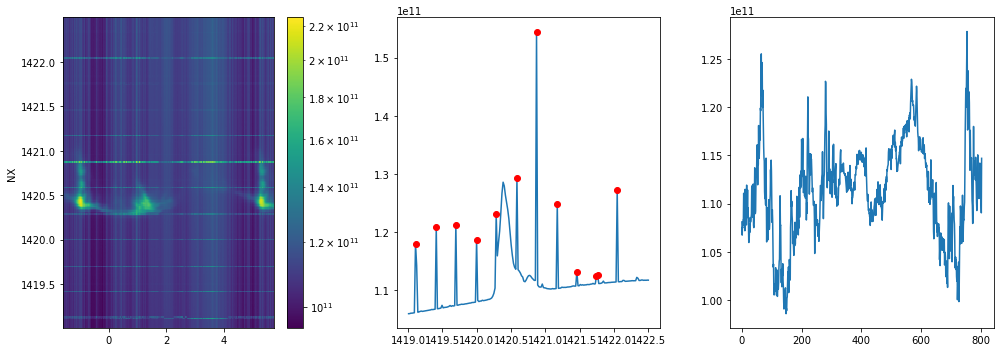

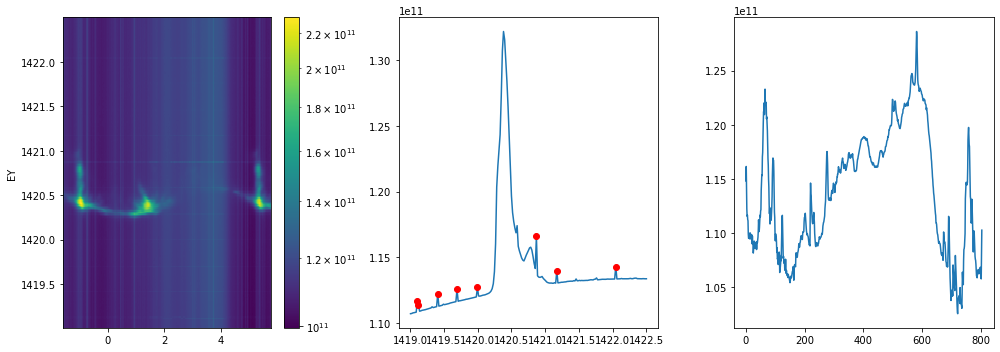

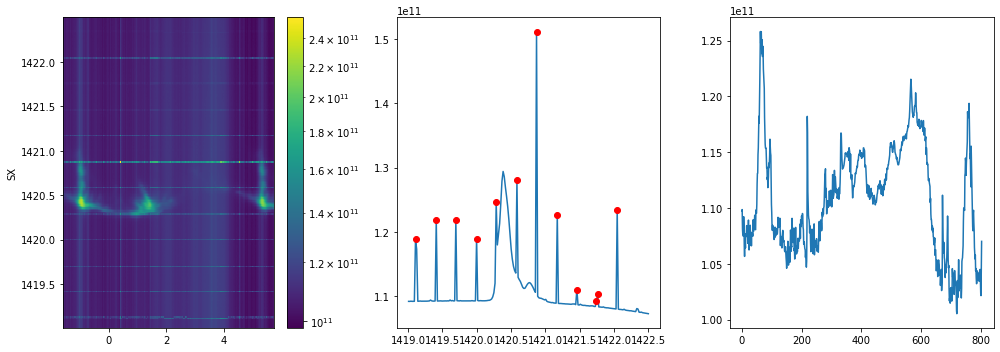

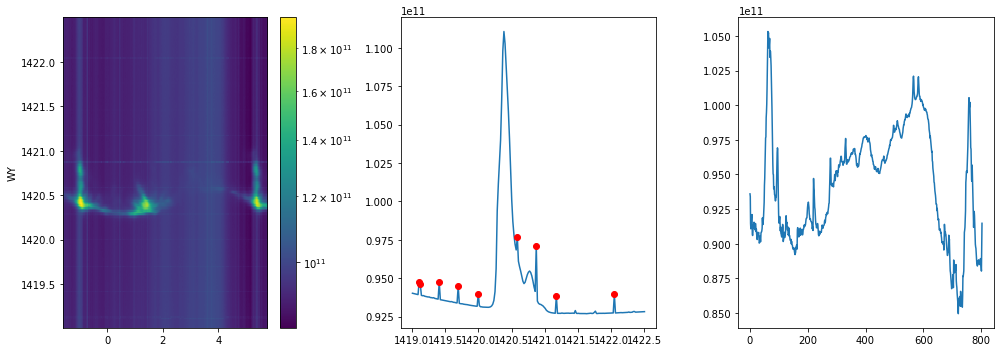

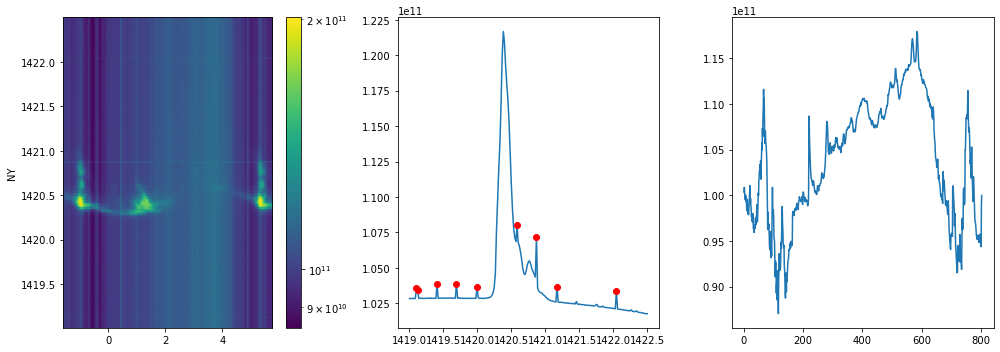

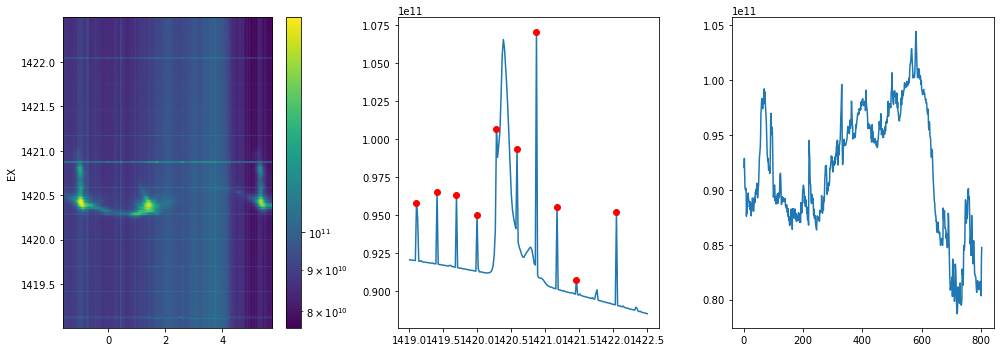

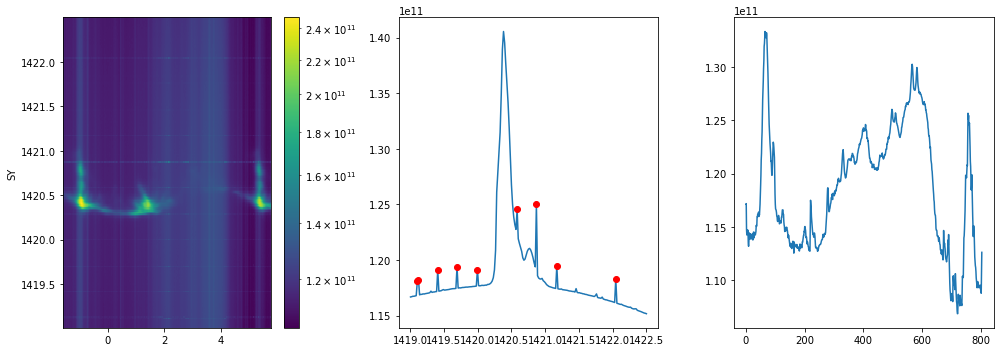

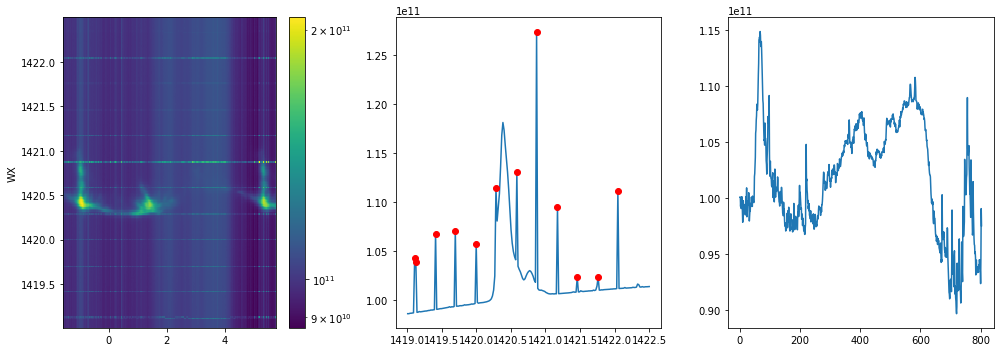

In [7]:
for i,(da,_,_) in enumerate(rdata):
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    da=da[:da.shape[0]//128*128,:]
    da=da.reshape(-1,128,da.shape[1]).mean(axis=1)
    plt.imshow(da.T,aspect='auto',norm=LogNorm(), extent=(ra[0],ra[-1],freq[0],freq[-1]),origin='lower' )
    plt.colorbar()
    plt.ylabel(wires[i])
    plt.subplot(1,3,2)
    v=da.mean(axis=0)
    plt.plot(freq,v)
    b,_=measure_rfi(v,returnbad=True)
    plt.plot(freq[b],v[b],'ro')
    plt.subplot(1,3,3)
    plt.plot(da.mean(axis=1))
    plt.tight_layout()


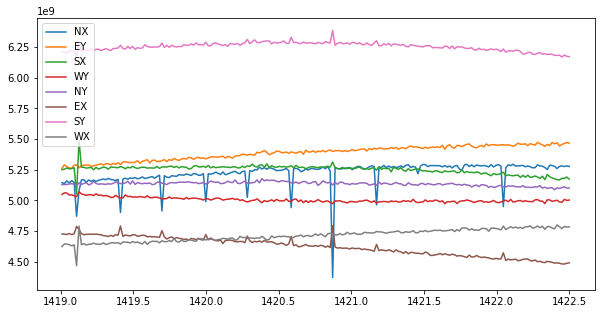

In [8]:
plt.figure(figsize=(10,5))
for i,(_,afreq,_) in enumerate(rdata):
    plt.plot(freq,afreq,label=wires[i])
plt.legend()

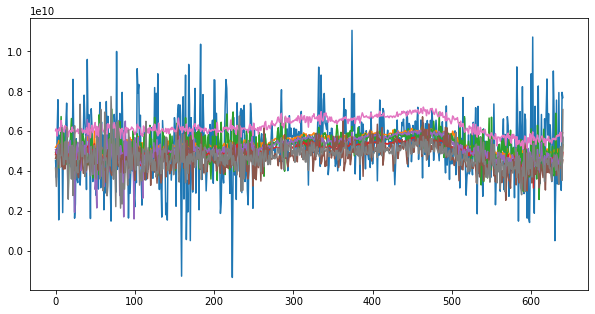

In [9]:
plt.figure(figsize=(10,5))
for i,(_,_,atime) in enumerate(rdata):
    plt.plot(atime,label=wires[i])



In [10]:
for i,(da,_,_) in enumerate(rdata):
    v=da.mean(axis=0)
    rfi,nrfi,snr=measure_rfi(v)
    print("Receiver %s : Ampl: %f, RFI badness: %f, RFI #ch:%i,  MW SNR: %f"%(wires[i],v.min()/1e11,rfi*1e3,nrfi,snr))

Receiver NX : Ampl: 1.059100, RFI badness: 6.520048, RFI #ch:12,  MW SNR: 1.213986
Receiver EY : Ampl: 1.107002, RFI badness: 0.356256, RFI #ch:8,  MW SNR: 1.194180
Receiver SX : Ampl: 1.072599, RFI badness: 6.074216, RFI #ch:12,  MW SNR: 1.206529
Receiver WY : Ampl: 0.926925, RFI badness: 0.581959, RFI #ch:9,  MW SNR: 1.198280
Receiver NY : Ampl: 1.017654, RFI badness: 0.498222, RFI #ch:9,  MW SNR: 1.195703
Receiver EX : Ampl: 0.884882, RFI badness: 2.810410, RFI #ch:10,  MW SNR: 1.204441
Receiver SY : Ampl: 1.151708, RFI badness: 0.822651, RFI #ch:9,  MW SNR: 1.220440
Receiver WX : Ampl: 0.986410, RFI badness: 4.468864, RFI #ch:12,  MW SNR: 1.197466
